In [32]:
import tensorflow as tf
print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization
# from tensorflow.keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

2.19.0


In [44]:
import os
import numpy as np
import pandas as pd
from pathlib import Path



# Parameters
WINDOW_SIZE = 100   # samples per window
STEP_SIZE = 50      # overlap
NUMBER_OF_SAMPLES = 200  # number of samples per appliance
DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')   # parent folder with subfolders for each appliance
LABELS = []
X = []
y = []
well_represented = ['Microwave', 'Television', 'Computer']


def process_file(file_path, label_idx):
    df = pd.read_csv(file_path)
    print(f"Processing file: {file_path}, Label index: {label_idx}")

    with open(file_path) as f:
      # Extract appliance name from filename
        appliance_name = f.readline().strip().split(",")[1]
        
    if appliance_name not in df.columns:
        return

    signal = df[appliance_name].fillna(0).values.astype(np.float32)
    signal = signal / np.max(np.abs(signal))

    for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
        window = signal[start:start + WINDOW_SIZE]
        X.append(window)
        y.append(label_idx)

def load_dataset(data_dir,well_represented=well_represented):
    global LABELS
    label_map = {name: i for i, name in enumerate(well_represented)}

    for class_dir in (sorted(Path(data_dir).iterdir())):
        if not class_dir.is_dir():
            continue

        class_name = class_dir.name
        if class_name not in well_represented:
            continue

        label_idx = label_map[class_name]
        LABELS.append(class_name)

        file_count = 0

        for file in class_dir.glob("*.csv"):

            if file_count >= NUMBER_OF_SAMPLES:
                break
            process_file(file, label_idx)
            file_count += 1

# Load and preprocess data
load_dataset(DATA_DIR)
X = np.array(X)[..., np.newaxis]  # shape: [samples, window_size, 1]
y = to_categorical(y, num_classes=len(LABELS))


Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_0.csv, Label index: 2
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv, Label index: 2
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_112.csv, Label index: 2
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_115.csv, Label index: 2
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_116.csv, Label index: 2
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_117.csv, Label index: 2
Processi

In [45]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train, "TRAIN")
print_class_distribution(y_val, "VALIDATION")
print_class_distribution(y_test, "TEST")




Class distribution in TRAIN set:
Computer            : 81235 samples
Microwave           : 116888 samples
Television          : 74790 samples

Class distribution in VALIDATION set:
Computer            : 27138 samples
Microwave           : 38957 samples
Television          : 24876 samples

Class distribution in TEST set:
Computer            : 27230 samples
Microwave           : 38866 samples
Television          : 24876 samples


In [46]:


def build_deep_cnn_lstm_model(window_size, num_classes):
    model = Sequential([
        Input(shape=(window_size, 1)),

        # 1st convolution block
        Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        # BatchNormalization(),
        MaxPooling1D(pool_size=2,strides=2),

        # 2nd block with dilation
        Conv1D(128, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
        # BatchNormalization(),
        MaxPooling1D(pool_size=2,strides=2),

        # 3rd block deeper dilation
        Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        # BatchNormalization(),
        MaxPooling1D(pool_size=2,strides=2),

        Dropout(0.5),  # regularization

        # LSTM layer for temporal modeling
        LSTM(128, return_sequences=False),

        Dense(128, activation='relu'),
        Dropout(0.3),

        # Final classification layer
        Dense(num_classes, activation='softmax')
    ])
    from keras.optimizers import Adam
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [29]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [51]:
model = build_deep_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_19 (Conv1D)              │ (None, 100, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 25, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,667 (1.29 MB)

 Trainable params: 337,667 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 201s 23ms/step - accuracy: 0.7661 - loss: 0.4678 - val_accuracy: 0.8270 - val_loss: 0.3501
Epoch 2/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 220s 26ms/step - accuracy: 0.8449 - loss: 0.3334 - val_accuracy: 0.8451 - val_loss: 0.3181
Epoch 3/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 184s 22ms/step - accuracy: 0.8490 - loss: 0.3223 - val_accuracy: 0.8688 - val_loss: 0.3018
Epoch 4/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 188s 22ms/step - accuracy: 0.8550 - loss: 0.3142 - val_accuracy: 0.8714 - val_loss: 0.2885
Epoch 5/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 179s 21ms/step - accuracy: 0.8622 - loss: 0.3046 - val_accuracy: 0.8800 - val_loss: 0.2784
Epoch 6/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 187s 22ms/step - accuracy: 0.8706 - loss: 0.2929 - val_accuracy: 0.8819 - val_loss: 0.2710
Epoch 7/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 191s 22ms/step - accuracy: 0.8795 - loss: 0.2778 - val_accuracy: 0.8715 - val_loss: 0.2768
Epoch 8/10
8529/8529 ━━━━━━━━━━━━━━━━━━━━ 189s 22ms/step - accuracy: 

In [52]:
predictions = model.predict(X_test)
probs = np.argmax(predictions,axis = 1)
print(probs)

2843/2843 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
[1 1 1 ... 0 1 1]


In [54]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

Confusion matrix, without normalization
[[27110   102    18]
 [  109 35306  3451]
 [   34  6638 18204]]


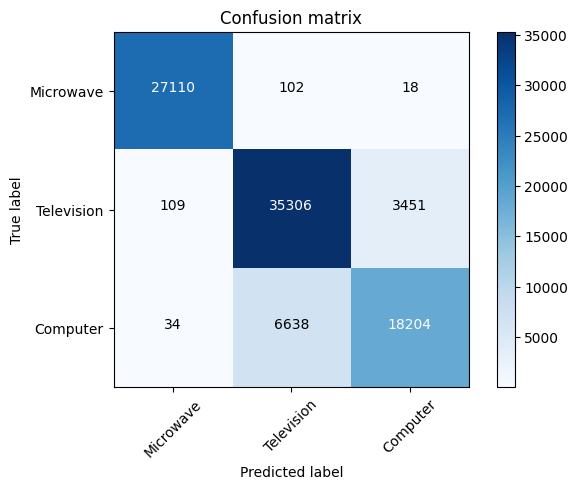

In [55]:
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, probs)
plot_confusion_matrix(cm,classes = well_represented)